In [2]:
# Load the needed modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.initializers import RandomNormal, Zeros


In [3]:
# Load the data from the file
df = pd.read_csv('https://raw.githubusercontent.com/magitz/possum/refs/heads/main/possum.csv')
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


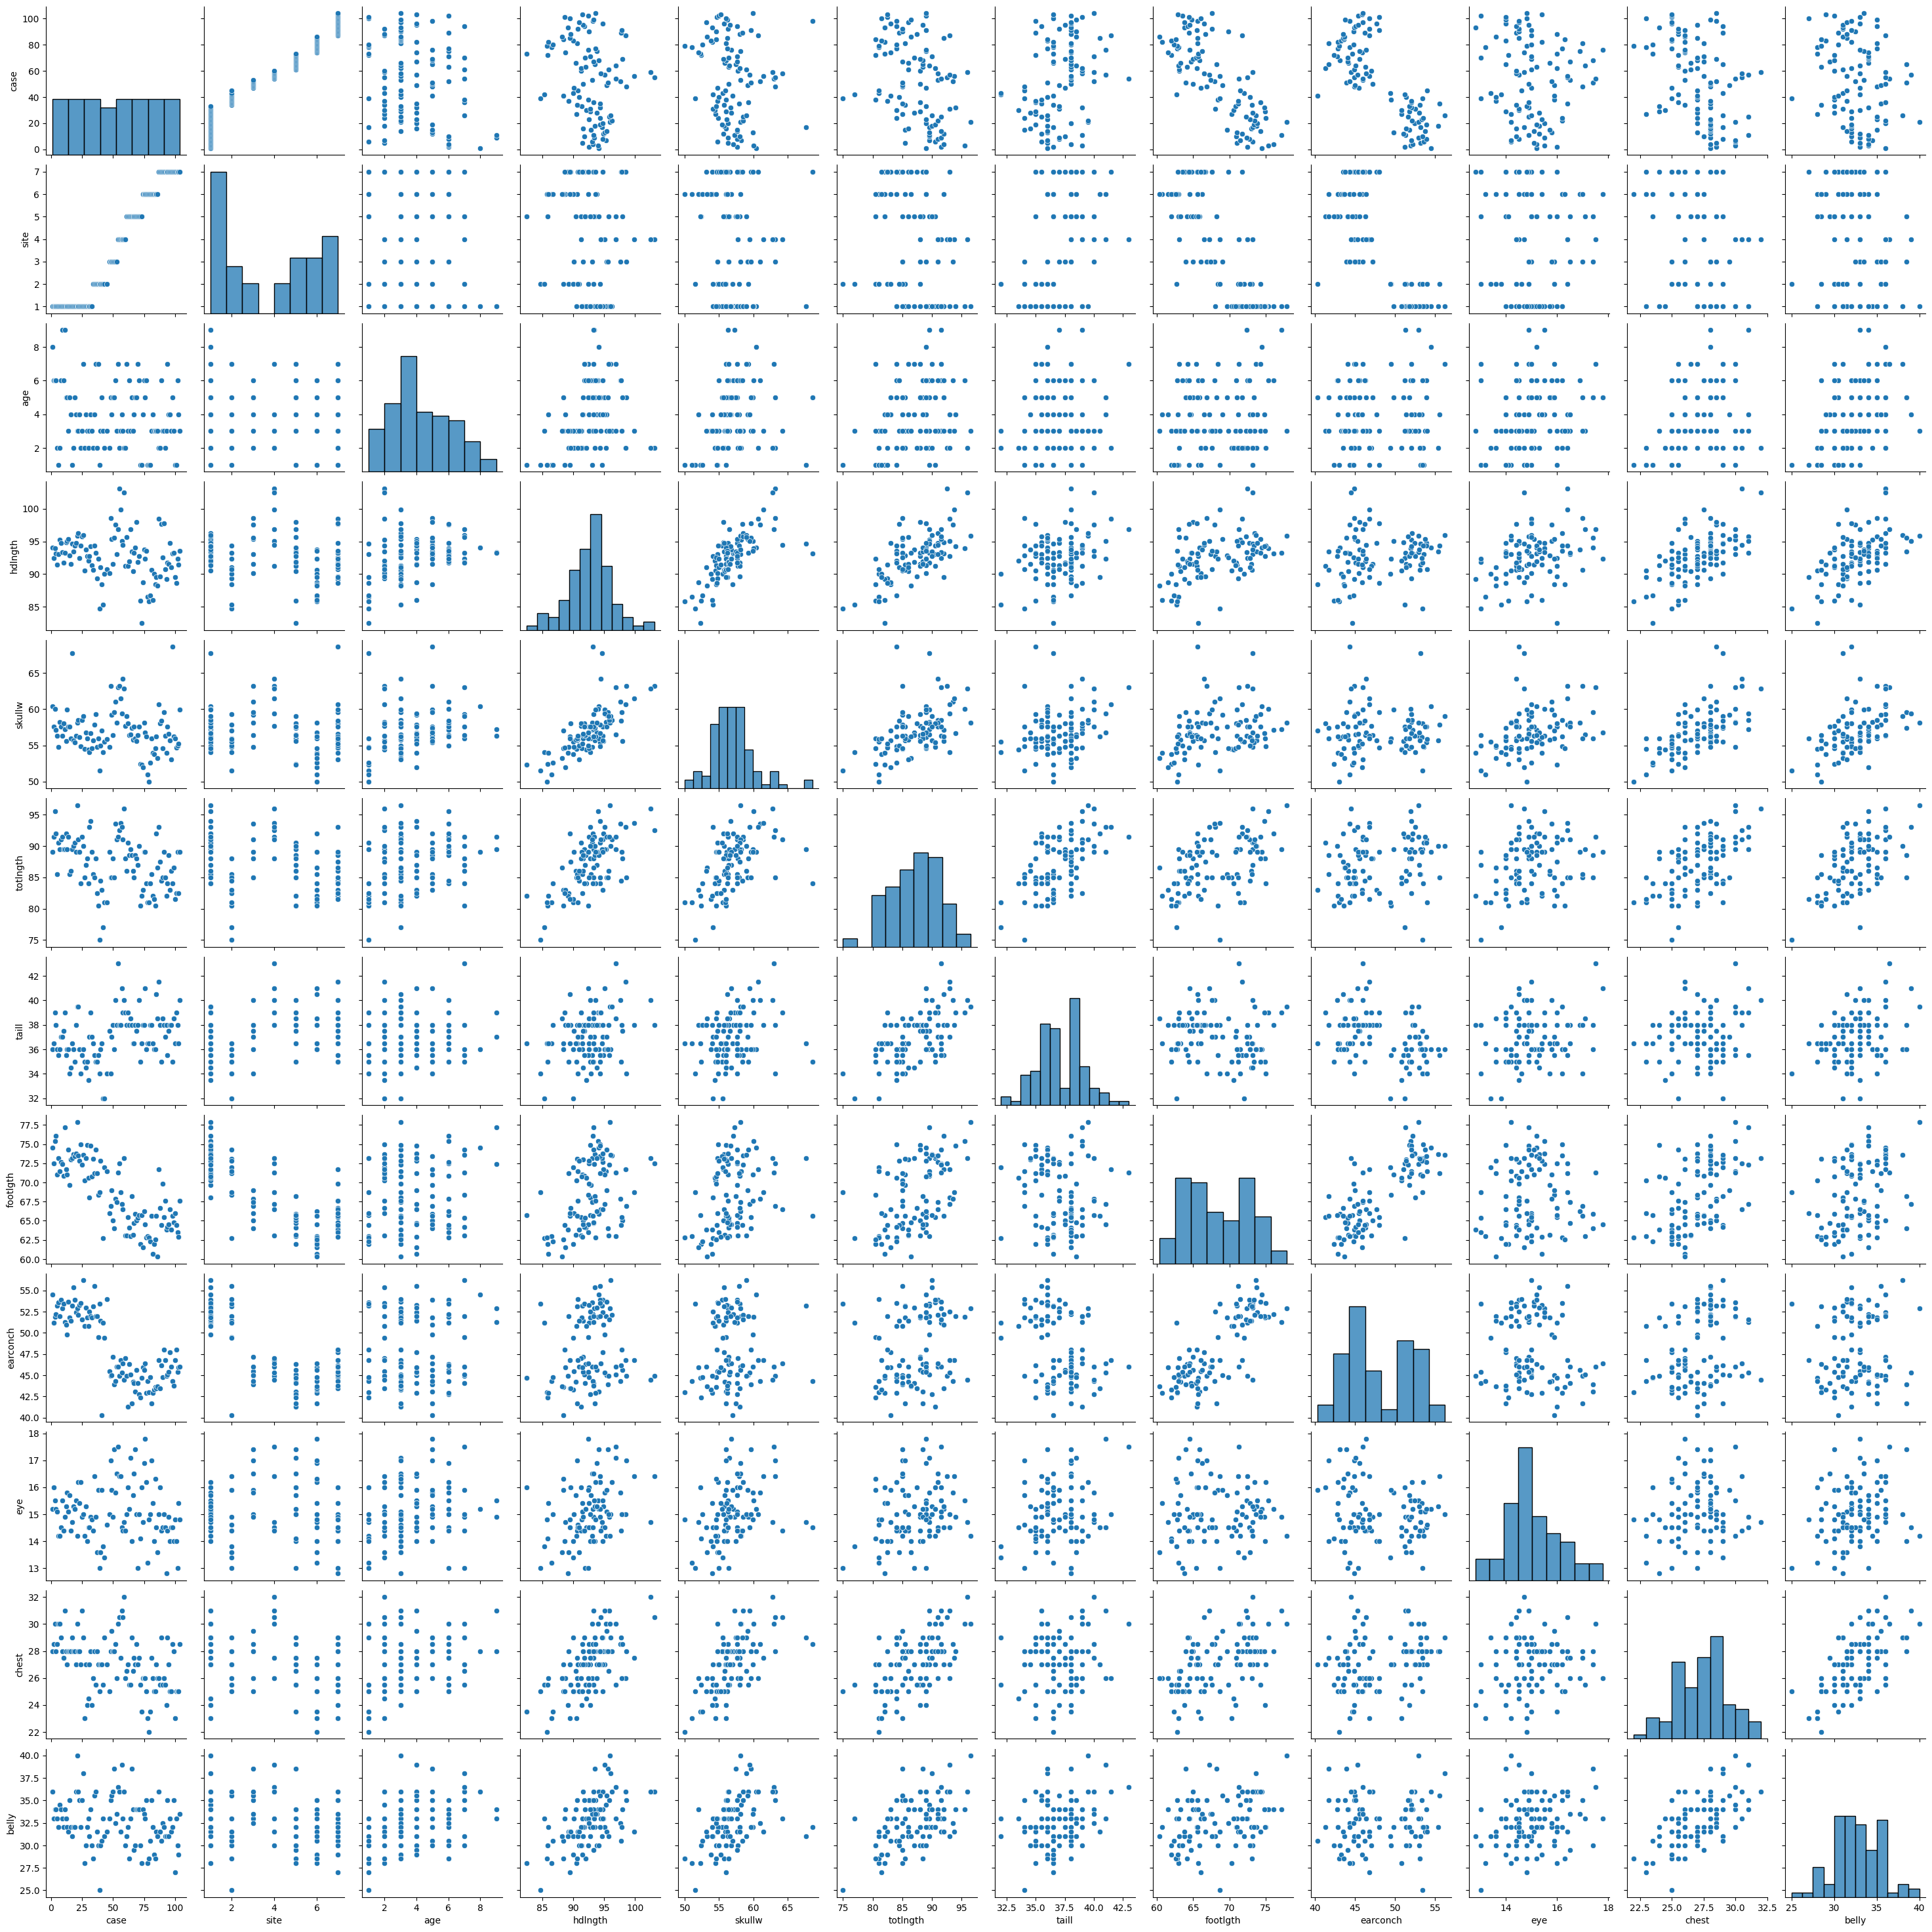

In [4]:
import seaborn as sns
sns.pairplot(df)

In [6]:
X=df[['belly', 'taill']]
y=df[['age']]


In [7]:
df.head(10)

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0
5,6,1,Vic,f,1,93.1,54.8,90.5,35.5,73.2,53.6,14.2,30.0,32.0
6,7,1,Vic,m,2,95.3,58.2,89.5,36.0,71.5,52.0,14.2,30.0,34.5
7,8,1,Vic,f,6,94.8,57.6,91.0,37.0,72.7,53.9,14.5,29.0,34.0
8,9,1,Vic,f,9,93.4,56.3,91.5,37.0,72.4,52.9,15.5,28.0,33.0
9,10,1,Vic,f,6,91.8,58.0,89.5,37.5,70.9,53.4,14.4,27.5,32.0


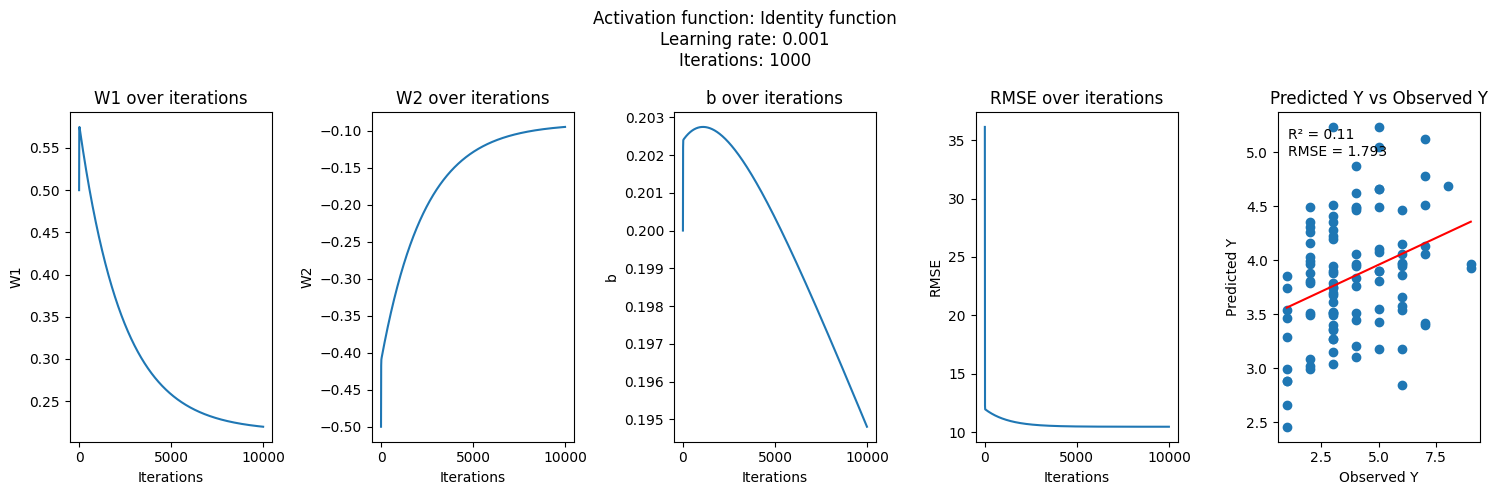

In [25]:
# Code from: https://medium.com/@soudanik/building-a-deep-learning-model-by-hand-bd51feccdfc7
# Modified to use the possum dataset belly, taill and age columns

# ANN model using backpropagation as a learning algorithm
# The ANN is composed of one hidden layer with one formal neuron with 2 input and 1 output variables

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Activation function : identity function
def activ_func(x):
    return x

# Derivative of the identity activation function
def activ_func_derivative(x):
    return 1

# dataset
#X1 = np.array([1, 2, 3])
#X2 = np.array([2, 3, 7])
#Y_true = np.array([3, 5, 10])

X1 = np.array(df['belly'])
X2 = np.array(df['taill'])
Y_true = np.array(df['age'])

# Initialize weights and bias
w1 = 0.5
w2 = -0.5
b = 0.2
# Learning rate
lr = 0.0001 # Must be small enough to converge - Many lr values can be tested

# Number of iterations for gradient descent
iterations = 10000 # Many iterations can be tested

# DataFrame to store the values

df1 = pd.DataFrame(columns=['dw1', 'dw2', 'db', 'w1', 'w2', 'b'])

# dw and db are the derivatives of loss function with respect to w and b respectively
# w and b are the weights and bias respectively

df2 = pd.DataFrame(columns=['loss','Z', 'Y_pred','dZ','RMSE'])
# loss, Z, Y_pred, dZ, RMSE : are the loss, weighted sum, dZ, predicted output and root mean square error respectively
# dZ is the derivative of loss function with respect to Z
# Single layer model
def single_layer_model(X1, X2, w1, w2, b):
    Z = w1*X1 + w2*X2 + b
    Y_pred = activ_func(Z)
    return Y_pred, Z

for i in range(iterations):
    
    # Forward propagation
    Y_pred, Z = single_layer_model(X1, X2, w1, w2, b)

    # Calculate the loss
    loss = (1/6)*np.sum((Y_true - Y_pred)**2)
    ## Note that loss is divided by 2 to make the derivation simpler
    ## For RMSE, loss is multiplied by 2 and then square rooted to get the RMSE usually used in regression problems
    RMSE = np.sqrt(loss*2)
    
    # Backward propagation
    
    dZ = (Y_pred - Y_true) * activ_func_derivative(Z)
 
    dw1 = np.mean(dZ * X1)
    dw2 = np.mean(dZ * X2)
    db = np.mean(dZ)

    # Update weights and bias
    w1 -= lr * dw1
    w2 -= lr * dw2
    b -= lr * db

    # Store the values in the DataFrame
    df1.loc[i] = [dw1, dw2, db, w1, w2, b]
    df2.loc[i] = [loss, Z, Y_pred, dZ, RMSE]

# Plots
## Add initialization values to the DataFrame df1 - for plotting purposes
init_values = [0, 0, 0, 0.5, -0.5, 0.2]
df_init = pd.DataFrame([init_values])
df_init.columns = df1.columns
# Concatenate df_init and df1
df1 = pd.concat([df_init, df1]).reset_index(drop=True)
# Plots
fig, axs = plt.subplots(1, 5, figsize=(15, 5))  # Create 5 subplots on one line

# Plot w1
axs[0].plot(range(iterations+1), df1['w1'])
axs[0].set_title('W1 over iterations')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('W1')

# Plot w2
axs[1].plot(range(iterations+1), df1['w2'])
axs[1].set_title('W2 over iterations')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('W2')

# Plot b
axs[2].plot(range(iterations+1), df1['b'])
axs[2].set_title('b over iterations')
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('b')
# Plot RMSE
axs[3].plot(range(iterations), df2['RMSE'])
axs[3].set_title('RMSE over iterations')
axs[3].set_xlabel('Iterations')
axs[3].set_ylabel('RMSE')

# Plot Y_true vs Y_pred (get last values of Y_pred at the last iteration)
Y_pred_final = df2['Y_pred'].tail(1).values[0]
#Y_true=np.array([3, 5, 10])
axs[4].scatter(Y_true, Y_pred_final)
axs[4].set_title('Predicted Y vs Observed Y')
axs[4].set_xlabel('Observed Y')
axs[4].set_ylabel('Predicted Y')

# Calculate linear regression between predicted and observed Y
slope, intercept = np.polyfit(Y_true, Y_pred_final, 1)

# Plot regression line
x = np.array([min(Y_true), max(Y_true)])
y = slope * x + intercept
axs[4].plot(x, y, color='red')

# Calculate R² and RMSE
r2 = r2_score(Y_true, Y_pred_final)
rmse = np.sqrt(mean_squared_error(Y_true, Y_pred_final))

# Show R² and RMSE on the plot
axs[4].text(0.05, 0.95, f'R² = {r2:.2f}\nRMSE = {rmse:.3f}', transform=axs[4].transAxes, verticalalignment='top')

# Set a common title for all subplots
fig.suptitle("Activation function: Identity function\nLearning rate: 0.001\nIterations: 1000")
plt.tight_layout()  # Adjust the padding between and around the subplots
plt.show()

In [23]:
Y_pred_final

array([4.6869426 , 3.9806557 , 3.96317654, 4.05801709, 4.02807597,
       3.85587403, 4.35750929, 4.15285763, 3.93323542, 3.66619294,
       3.96317654, 4.07549624, 3.80845376, 3.69864265, 4.65700149,
       3.95071458, 3.54141127, 3.80845376, 3.90329431, 4.49726151,
       5.23348953, 4.35500069, 4.46732039, 3.99813485, 4.51474067,
       5.12618703, 3.02480546, 3.51147016, 3.90329431, 4.26517734,
       3.493991  , 3.96317654, 3.27436879, 2.99235575, 4.62455177,
       4.78178315, 3.7934832 , 3.41662961, 2.46077938, 3.36920934,
       3.43160017, 4.40743816, 3.96819374, 3.88832375, 3.88581515,
       4.65700149, 4.48229095, 4.49726151, 5.23599813, 3.53890267,
       3.94820598, 4.13286987, 4.49726151, 3.50896156, 4.8716065 ,
       3.74355433, 4.30758041, 3.08468769, 3.39915045, 3.52393211,
       2.85009492, 3.7909746 , 5.04631704, 4.20027791, 3.21197796,
       3.17952824, 4.10543736, 4.05801709, 3.86833599, 3.46404988,
       2.88254464, 4.05801709, 3.94820598, 3.55387323, 4.46732

In [24]:
Y_true

array([ 3,  5, 10])

In [8]:
import torch

In [19]:
# Define the model
# The model has 2 layers:
# - The first layer has 2 neurons and uses the ReLU activation function
# - The second layer has 1 neuron and uses the linear activation function
# The input to the model is a tensor with 2 elements and the output is a tensor with 1 element

model = torch.nn.Sequential(
    torch.nn.Linear(2, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1)
)

#model = torch.nn.Sequential(
#    torch.nn.Linear(2, 1)
#)

# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


In [20]:
# Convert the data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float)
y_tensor = torch.tensor(y.values, dtype=torch.float)

# Train the model
for epoch in range(10):
    # Forward pass
    y_pred = model(X_tensor)

    # Print the predictions and known values
    print(y_pred)
    print(y_tensor)
    print('-----')

    
    # Compute the loss
    loss = loss_fn(y_pred, y_tensor)
    
    # Print the loss
    print(loss.item())
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Backward pass
    loss.backward()

    # Print the gradients
    print(model[0].weight.grad)
    print(model[0].bias.grad)
    print(model[2].weight.grad)
    print(model[2].bias.grad)
    print('-----')
    
    # Update the weights
    optimizer.step()
    
    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        print(epoch, loss.item())

tensor([[-13.6631],
        [-13.5160],
        [-14.3330],
        [-14.0450],
        [-13.3720],
        [-13.1310],
        [-13.5175],
        [-13.7570],
        [-13.6600],
        [-13.7070],
        [-14.3330],
        [-13.2280],
        [-13.2750],
        [-13.2264],
        [-12.9900],
        [-12.8430],
        [-13.3219],
        [-13.2750],
        [-12.9870],
        [-14.2391],
        [-15.0592],
        [-14.6711],
        [-13.5661],
        [-12.6989],
        [-13.4221],
        [-13.8572],
        [-12.5988],
        [-12.6489],
        [-12.9870],
        [-12.6520],
        [-13.4659],
        [-14.3330],
        [-13.3689],
        [-13.0794],
        [-13.4706],
        [-13.3751],
        [-12.9384],
        [-12.9369],
        [-12.0197],
        [-13.0809],
        [-13.2734],
        [-12.2200],
        [-12.0259],
        [-12.6504],
        [-13.8040],
        [-12.9900],
        [-13.9026],
        [-14.2391],
        [-13.9057],
        [-14.4755],


In [61]:
# Define a simple neural network model
model = Sequential([
    Dense(2, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05), bias_initializer=Zeros()),
    Dense(1, activation='linear', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05), bias_initializer=Zeros())
])

In [62]:
# Compile the model (same as before)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Added 'mae' for accuracy
# Build the model with the input shape
# This initializes the weights of the model
model.build(input_shape=(None, X.shape[1]))  # (None, 2) for your input shape



In [63]:
# Function to calculate loss, accuracy, and gradients for given parameters
def calculate_metrics(input_data, target_data, new_weights):
    # Set model weights to the provided values
    # model.set_weights(new_weights)

    # Calculate loss and accuracy
    loss, accuracy = model.evaluate(input_data, target_data, verbose=0)

    # Calculate gradients using tf.GradientTape
    with tf.GradientTape() as tape:
        y_pred = model(input_data)  # Forward pass
        loss_value = model.compute_loss(x=input_data, y=target_data, y_pred=y_pred)  # Updated line
    gradients = tape.gradient(loss_value, model.trainable_weights)

    # Print weights and gradients in a table with clearer labels
    weights_data = []
    for layer_num, layer in enumerate(model.layers):
        layer_weights = layer.get_weights()  # Get weights for the current layer

        # Weights
        weight_values = layer_weights[0].flatten()
        num_neurons_in_layer = layer_weights[0].shape[1]
        for neuron_index in range(num_neurons_in_layer):
            for weight_index_in_neuron in range(layer_weights[0].shape[0]):
                w = weight_values[neuron_index * layer_weights[0].shape[0] + weight_index_in_neuron]
                # Access the corresponding gradient for this weight
                g = gradients[layer_num * 2].numpy().flatten()[neuron_index * layer_weights[0].shape[0] + weight_index_in_neuron]
                weights_data.append([f"Layer {layer_num + 1}, Neuron {neuron_index + 1}, Weight {weight_index_in_neuron + 1}", w, g])

        # Biases
        bias_values = layer_weights[1].flatten()
        for bias_index, b in enumerate(bias_values):
            # Access the corresponding gradient for this bias
            g = gradients[layer_num * 2 + 1].numpy().flatten()[bias_index]
            weights_data.append([f"Layer {layer_num + 1}, Neuron {bias_index + 1}, Bias", b, g])

    return loss, accuracy, gradients, weights_data

In [64]:
def evaluate_model(model, X, y):
  current_weights = model.get_weights()

  loss, accuracy, gradients, weights_data = calculate_metrics(X, y, current_weights)

  # Print the results
  print("Loss:", loss)
  print("Accuracy (MAE):", accuracy)
  df_weights = pd.DataFrame(weights_data, columns=["Parameter", "Value", "Gradient"])
  print(df_weights.to_string())

  return loss, accuracy, current_weights, gradients

loss, accuracy, current_weights, gradients = evaluate_model(model, X, y)

Loss: 18.25679588317871
Accuracy (MAE): 3.827232837677002
                     Parameter     Value  Gradient
0  Layer 1, Neuron 1, Weight 1 -0.010368  0.000000
1  Layer 1, Neuron 1, Weight 2  0.031449 -3.973519
2  Layer 1, Neuron 2, Weight 1 -0.109443  0.000000
3  Layer 1, Neuron 2, Weight 2 -0.016224 -4.800104
4      Layer 1, Neuron 1, Bias  0.000000  0.000000
5      Layer 1, Neuron 2, Bias  0.000000 -0.145044
6  Layer 2, Neuron 1, Weight 1 -0.045288  0.000000
7  Layer 2, Neuron 1, Weight 2  0.018949 -2.484919
8      Layer 2, Neuron 1, Bias  0.000000 -7.654466


In [71]:
def updated_weights(current_weights, gradients, learning_rate=0.01):

  # Update weights
  updated_weights = []
  for i, (weight, gradient) in enumerate(zip(model.trainable_weights, gradients)):
      updated_weight = weight - learning_rate * gradient
      updated_weights.append(updated_weight)

  # Set the updated weights to the model
  model.set_weights(updated_weights)

  return

learning_rate = 0.1
updated_weights(current_weights, gradients, learning_rate)

In [72]:
evaluate_model(model, X, y)

Loss: 11419.263671875
Accuracy (MAE): 106.62036895751953
                     Parameter     Value      Gradient
0  Layer 1, Neuron 1, Weight 1 -0.010368      0.000000
1  Layer 1, Neuron 1, Weight 2  1.620857   5869.250000
2  Layer 1, Neuron 2, Weight 1 -0.109443      0.000000
3  Layer 1, Neuron 2, Weight 2  1.903817   7081.191406
4      Layer 1, Neuron 1, Bias  0.000000      0.000000
5      Layer 1, Neuron 2, Bias  0.058017    215.995026
6  Layer 2, Neuron 1, Weight 1 -0.045288      0.000000
7  Layer 2, Neuron 1, Weight 2  1.012916  22713.654297
8      Layer 2, Neuron 1, Bias  3.061786    213.240723


(11419.263671875,
 106.62036895751953,
 [array([[-0.01036772,  1.6208569 ],
         [-0.10944293,  1.9038173 ]], dtype=float32),
  array([0.       , 0.0580175], dtype=float32),
  array([[-0.04528809],
         [ 1.0129164 ]], dtype=float32),
  array([3.0617864], dtype=float32)],
 [<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
  array([[   0.    , 5869.25  ],
         [   0.    , 7081.1914]], dtype=float32)>,
  <tf.Tensor: shape=(2,), dtype=float32, numpy=array([  0.     , 215.99503], dtype=float32)>,
  <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
  array([[    0.   ],
         [22713.654]], dtype=float32)>,
  <tf.Tensor: shape=(1,), dtype=float32, numpy=array([213.24072], dtype=float32)>])